In [1]:
import os
import sys
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import skimage.io

from collections import defaultdict
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import re
import tifffile as tiff
import pickle

import networkx as nx
from sklearn.model_selection import train_test_split

import torch_geometric.utils
import torch

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
p_dir = (Path().cwd().parents[0]).absolute()

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
data_dir = (Path().cwd().parents[0] / 'data').absolute()

In [5]:
import graph
import torch
import torch_geometric.utils
import networkx as nx
import lightning.pytorch as pl
import torch.utils.data as data

spatial_omics_folder = (Path().cwd().parents[0]).absolute() / 'data' / 'spatial_omics_graph'
process_path = (Path().cwd().parents[0]).absolute() / 'data' / 'torch_graph_data'

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [6]:
def visualize_graph(G, pos, color, **kwargs):
    fig, ax = plt.subplots(figsize=(15,15))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=pos, with_labels=False, 
                     node_color=color, ax=ax, **kwargs)
    ax.axis('equal')
    ax.invert_yaxis()
    ax.set_facecolor('k')
    plt.show()

## Read data Frame

In [7]:
import scanpy as sc
import anndata as ad 
# Import spatial omics library
import athena as ath
from spatialOmics import SpatialOmics

import networkx as nx
import matplotlib 

# Save data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'adata'

# adata_combined = ad.read_h5ad(save_path / 'all.h5ad')
adata_foll = ad.read_h5ad(save_path / 'foll.h5ad')
name_map = {'0': 'Ki67+ B-cell', '4': 'Ki67+', '5': 'Ki67+ Macrophage', '6':'CD20+ Macrophage', '3':'Plasma Cell', '8':'Other', '11':'Macrophage', '1':'B-cell', '7':'FDC', '18':'Dendritic cell', '13':'Other'}

adata_foll.obs['name'] = (
    adata_foll.obs["merged"]
    .map(lambda x: name_map.get(x, x))
    .astype("category")
)

adata_foll.uns["name_colors"] = sc.pl.palettes.vega_20_scanpy[:len(np.unique(adata_foll.obs['name']))]

# Extract node class and colors
var = 'name'

cluster_label_order = adata_foll.uns[f'dendrogram_{var}']['categories_ordered']

colors = adata_foll.uns[f"{var}_colors"]
labels = adata_foll.obs[var].cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

df_cell_info = adata_foll.obs.copy()


c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


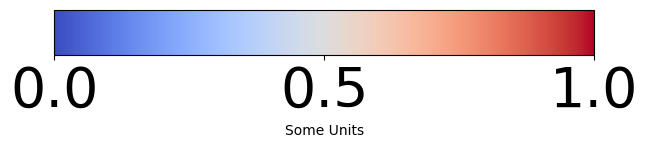

In [8]:

import matplotlib.pyplot as plt
import matplotlib as mpl

# Make a figure and axes with dimensions as desired.
fig = plt.figure(figsize=(6, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])

# Set the colormap and norm to correspond to the data for which
# the colorbar will be used.
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=1)

# ColorbarBase derives from ScalarMappable and puts a colorbar
# in a specified axes, so it has everything needed for a
# standalone colorbar.  There are many more kwargs, but the
# following gives a basic continuous colorbar with ticks
# and labels.
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.ax.tick_params(labelsize=40)
cb1.set_label('Some Units')

# Get Dataset

In [9]:
import graph
import torch

from torch_geometric.loader import DataLoader
seed = torch.Generator().manual_seed(42)

name = 'NIH_pos'

# Crate dataset
dataset = graph.GraphDatasetPos(process_path / name, process_path / name / 'info.csv', 2, y_name='covid')

train_set, val_set, test_set = graph.train_test_val_split(dataset)

# Create Dataloader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [10]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.nc}')

Dataset: GraphDatasetPos(442):
Number of graphs: 442
Number of features: 6
Number of classes: 2


In [11]:
print(f'Train set: {len(train_set)}, val set: {len(test_set)}, val set: {len(val_set)}')

Train set: 213, val set: 176, val set: 53


# Load model

Get the best model from all

In [12]:
### Load GNN 
from graph.model import NodeLevelGNN, GraphLevelGNN, GraphLevelGNN_Moprh, GraphLevelGNN_Pos
from pytorch_lightning.utilities.model_summary import ModelSummary

# Model path
condition = '082923_Covid_pos'
checkpoint_folder = (Path().cwd().parents[0]).absolute() / 'data' / "saved_models" / f"Graph_GNNs_{condition}" 
project_name = f'SF_{condition}'

# Model parameters
NUM_LAYERS = 2
HIDDEN_CHANNELS = 16
pool = 'attention2'
model ='GAT'
fold =2
pl.seed_everything(42)

# Load model
CHECKPOINT_PATH = checkpoint_folder / f'{model}_{NUM_LAYERS}_{HIDDEN_CHANNELS}_{fold}' / pool
checkpoint = CHECKPOINT_PATH / f"GraphLevel{model}" / f"GraphLevel{model}.ckpt" 
graph_model = GraphLevelGNN_Pos.load_from_checkpoint(checkpoint, map_location=torch.device('cpu'))
graph_model.eval()

# Print model
summary = ModelSummary(graph_model)
print(summary)

Global seed set to 42


   | Name        | Type             | Params
--------------------------------------------------
0  | model       | GAT              | 5.1 K 
1  | fnn_layer   | Linear           | 272   
2  | selu        | SELU             | 0     
3  | head        | Linear           | 34    
4  | loss_module | CrossEntropyLoss | 0     
5  | train_acc   | BinaryAccuracy   | 0     
6  | train_auroc | BinaryAUROC      | 0     
7  | train_f1    | BinaryF1Score    | 0     
8  | valid_acc   | BinaryAccuracy   | 0     
9  | valid_auroc | BinaryAUROC      | 0     
10 | valid_f1    | BinaryF1Score    | 0     
11 | pool        | Attention_module | 281   
--------------------------------------------------
5.7 K     Trainable params
0         Non-trainable params
5.7 K     Total params
0.023     Total estimated model params size (MB)


# Graph explainer

In [13]:
from torch_geometric.explain import Explainer, PGExplainer, GNNExplainer, CaptumExplainer, AttentionExplainer
from torch_geometric.utils import remove_self_loops, to_undirected
import random
from collections import defaultdict

def aggregate_edge_directions(edge_mask, edge_index):
    edge_mask_dict = defaultdict(float)
    for val, u, v in list(zip(edge_mask, *edge_index)):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
    return edge_mask_dict
    

In [14]:
data = dataset[6]
# data = dataset[4]
# data = dataset[287]
data = dataset[290]
print(data.x.shape[0], data.y, data.name)
data = data.to(graph_model.device)

3293 tensor(0) Y:\coskun-lab\Thomas\11_snowflakes\data\torch_graph_data\NIH_pos\pt\07_T3_39.pt


In [15]:
data.name

'Y:\\coskun-lab\\Thomas\\11_snowflakes\\data\\torch_graph_data\\NIH_pos\\pt\\07_T3_39.pt'

In [16]:
data

Data(edge_index=[2, 21279], num_nodes=3293, x=[3293, 6], pos=[3293, 2], node_types=[3293], label=0, covid=0, train_mask=[3293], test_mask=[3293], edge_attr=[21279, 2], y=0, name='Y:\coskun-lab\Thomas\11_snowflakes\data\torch_graph_data\NIH_pos\pt\07_T3_39.pt')

## Plot cell type graphs

In [17]:
# Get dataset and foll number
dataset_name, foll = data.name.split('\\')[-1][3:-3].split('_')

# Get node info dataframe
df_cell_info_foll = df_cell_info[(df_cell_info.Foll == int(foll)) & (df_cell_info.Dataset == dataset_name)]

# Get spdata
path = spatial_omics_folder / f'07_{dataset_name}.hdf5'
spadata = SpatialOmics.from_h5py(path)

# Assign node type
spadata.obs[str(foll)]['name'] = df_cell_info_foll.name.tolist()

# Get graph information
G = spadata.G[str(foll)]['contact']
data_graph = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
G_new =  torch_geometric.utils.to_networkx(data, to_undirected=True)
G_new.remove_edges_from(nx.selfloop_edges(G_new))
pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
cell_types =  spadata.obs[str(foll)]['name'].loc[np.array(G.nodes())].to_numpy()
node_colors = tuple(colors_rgb_dict[n]/255 for n in cell_types)



In [18]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)

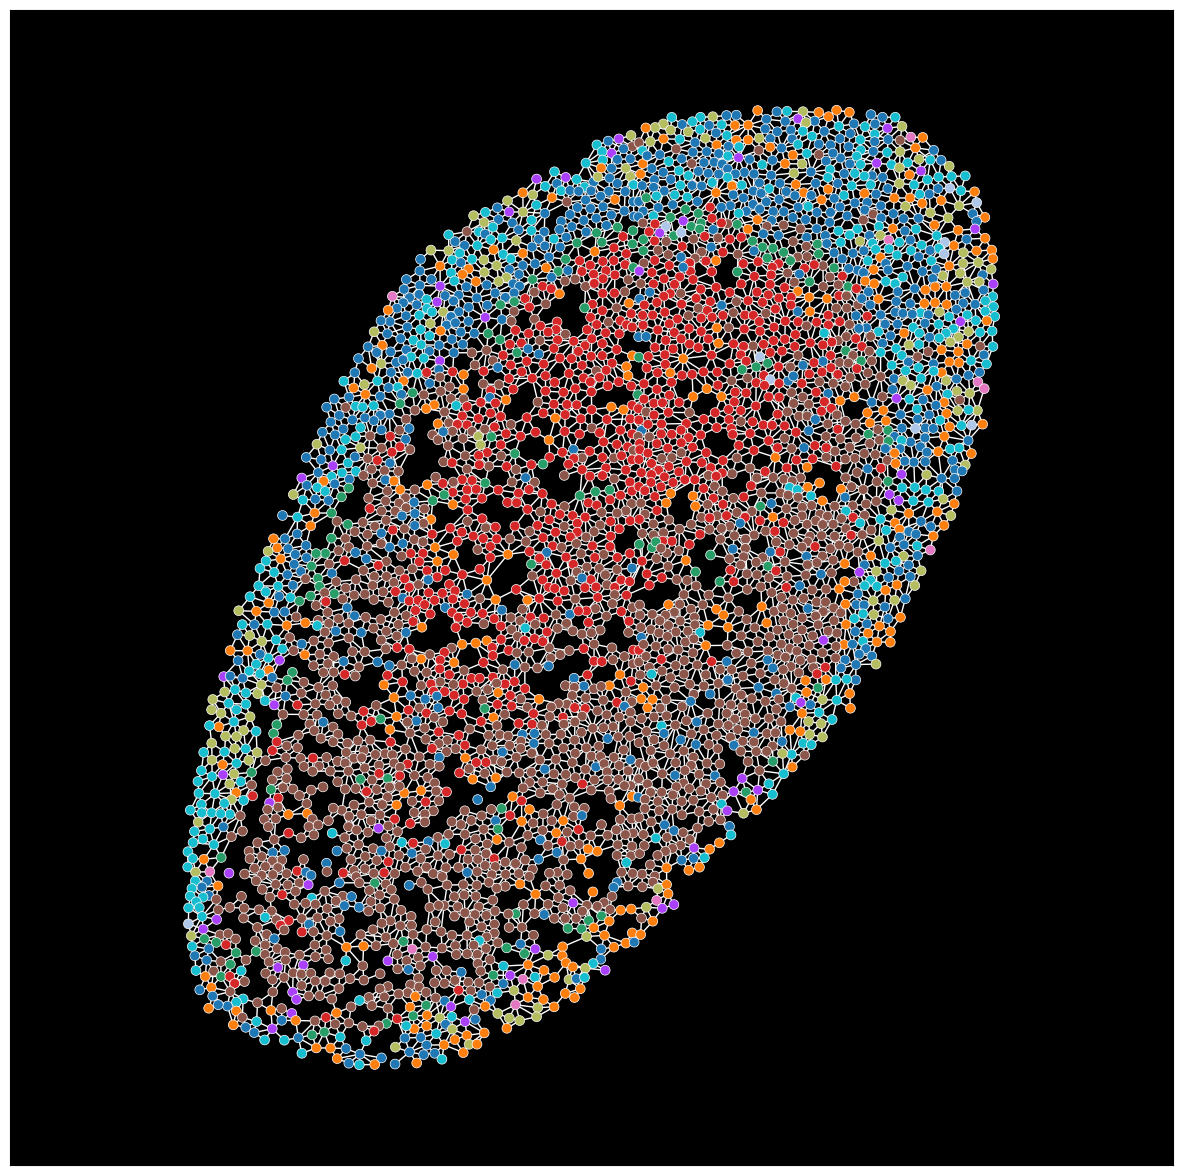

In [19]:
visualize_graph(G, pos, node_colors, 
    edgecolors='w',
    linewidths=0.5,
    node_size=50, 
    edge_color='w', 
    width=1, 
    arrows=False)

## IG on edges 

In [20]:
explainer = Explainer(
    model=graph_model,
    algorithm=CaptumExplainer('IntegratedGradients'),
    explanation_type="model",
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
explanation = explainer(data.x, edge_index, target=data.y, edge_attr=edge_attr, data=data)

c:\Users\thu71\AppData\Local\anaconda3\envs\torch\Lib\site-packages\torch_geometric\explain\explainer.py:189: UserWarning: The 'target' should not be provided for the explanation type 'model'
  warnings.warn(


In [21]:
# Get edge_color 
edge_color = explanation.edge_mask.detach().cpu().numpy()
# if data.y ==0:
#     edge_color = -edge_color
edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

edges = tuple(edge_color_dict.keys())
edge_color = np.array(list(edge_color_dict.values()))
edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
edge_color = np.clip(edge_color, a_min=0, a_max=1)


17986 8993 8993


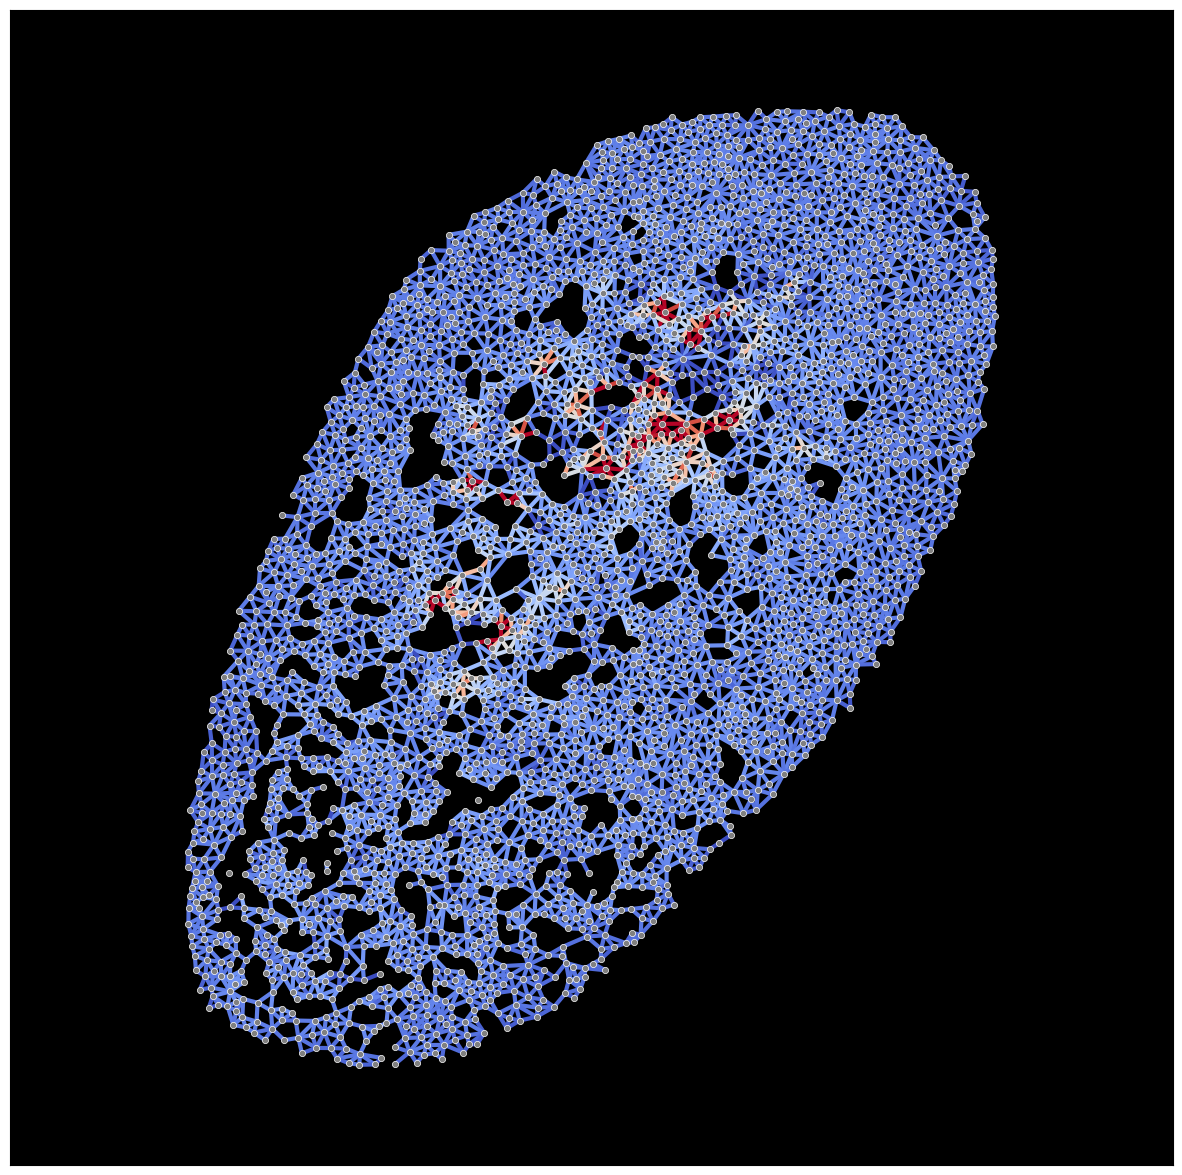

In [22]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
classes = data.node_types.cpu().numpy()
        
visualize_graph(G, pos, 'gray', 
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_color, 
    # width=[x * 5 for x in edge_color], 
    width=3,
    arrows=False)

In [23]:
explainer = Explainer(
    model=graph_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
explanation = explainer(data.x, edge_index, target=data.y, edge_attr=edge_attr, data=data)

In [24]:
# Get edge_color 
edge_color = explanation.edge_mask.detach().cpu().numpy()
if data.y ==0:
    edge_color = -edge_color
edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

edges = tuple(edge_color_dict.keys())
edge_color = np.array(list(edge_color_dict.values()))
edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
edge_color = np.clip(edge_color, a_min=0, a_max=1)

17986 8993 8993


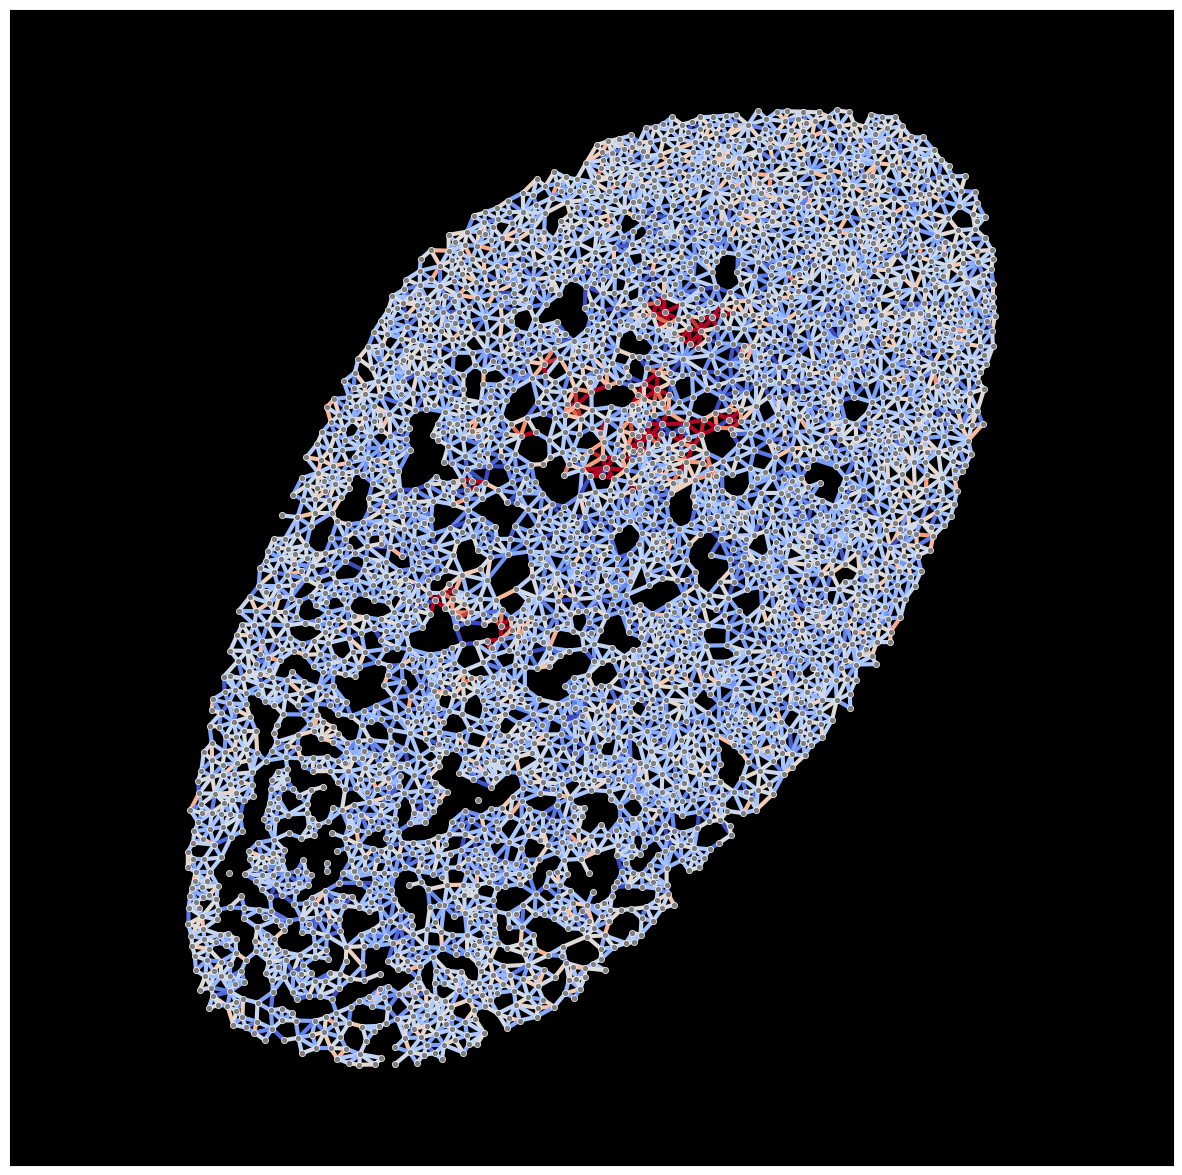

In [25]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
classes = data.node_types.cpu().numpy()
        
visualize_graph(G, pos, 'gray', 
    edgecolors='w',
    linewidths=0.5,
    node_size=20, 
    edgelist=edges, 
    edge_cmap=plt.cm.coolwarm, 
    edge_color=edge_color, 
    # width=[x * 5 for x in edge_color], 
    width=3,
    arrows=False)

## GNN explainer node level importance

In [26]:
explainer = Explainer(
    model=graph_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type="model",
    node_mask_type='object',
    edge_mask_type=None,
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
    # Include only the top 10 most important edges:
    # threshold_config=dict(threshold_type='topk', value=20),
)

In [27]:
explanation = explainer(data.x, data.edge_index, target=data.y, edge_attr=data.edge_attr, data=data)

In [28]:
# Get edge_color 
node_color = explanation.node_mask.detach().cpu().numpy()
node_color = (node_color-node_color.min())/(node_color.max()-node_color.min())

17986 8993 8993


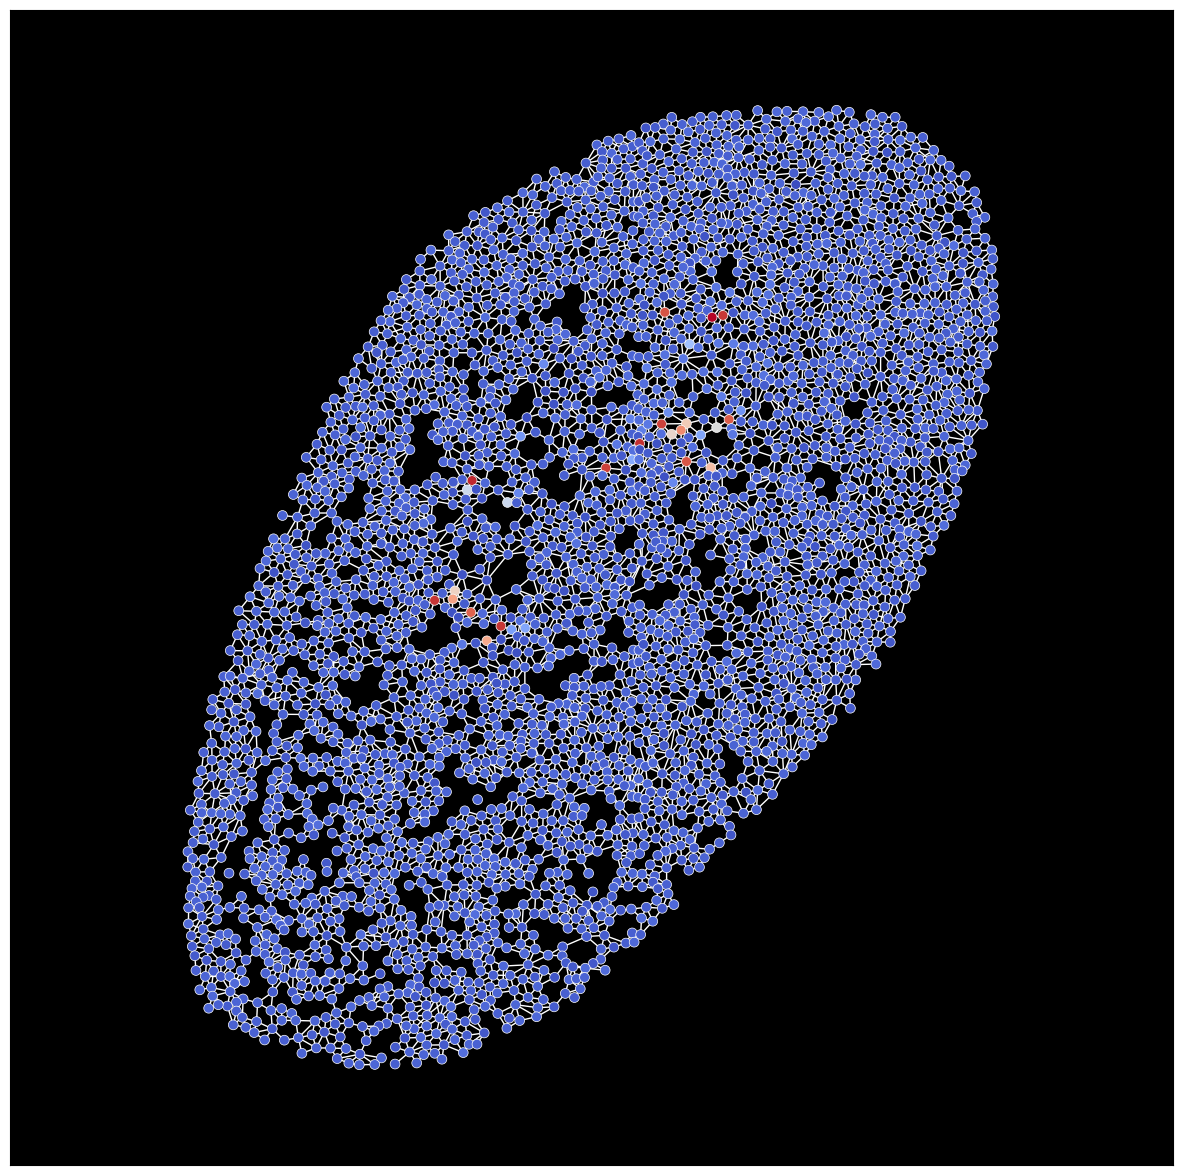

In [29]:
G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)
edges = G.edges()
print(len(edge_index[0]), len(edge_color), len(edges))

pos = data.pos.cpu().numpy()
classes = data.node_types.cpu().numpy()
        
visualize_graph(G, pos, node_color, 
    edgecolors='w',
    linewidths=0.5,
    node_size=50, 
    edge_color='w', 
    cmap='coolwarm',
    arrows=False)

## IG explainer node attributes

In [34]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)
scores = []
mean_val = []

for batch in tqdm(loader):

    break

  0%|          | 0/442 [00:00<?, ?it/s]

In [35]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)
scores = []
mean_val = []

for batch in tqdm(loader):
    explainer = Explainer(
        model=graph_model,
        algorithm=CaptumExplainer('IntegratedGradients'),
        explanation_type="model",
        node_mask_type="attributes",
        edge_mask_type=None,
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='probs',
        ),
    )
    batch = batch.to(graph_model.device)
    explanation = explainer(batch.x, batch.edge_index, edge_attr=batch.edge_attr, data=batch)
    if int(batch.y) == 0:
        scores.append(-explanation.node_mask.sum(dim=0))
    else:
        scores.append(explanation.node_mask.sum(dim=0))
    mean_val.append(batch.x.cpu().numpy().mean(axis=0))

  0%|          | 0/442 [00:00<?, ?it/s]

In [36]:
from typing import Dict, List, Optional, Union

def _visualize_score(
    score: torch.Tensor,
    labels: List[str],
    path: Optional[str] = None,
    top_k: Optional[int] = None,
):
    import matplotlib.pyplot as plt
    import pandas as pd

    df = pd.DataFrame({'score': score}, index=labels)
    df = df.sort_values('score', ascending=False)
    df = df.round(decimals=3)

    if top_k is not None:
        df = df.head(top_k)
        title = f"Feature importance for top {len(df)} features"
    else:
        title = f"Feature importance for {len(df)} features"

    ax = df.plot(
        kind='barh',
        figsize=(4, 3),
        title=title,
        ylabel='Feature label',
        xlim=[float(df['score'].min()) - 0.2, float(df['score'].max()) + 0.2],
        legend=False,
    )
    plt.gca().invert_yaxis()
    ax.bar_label(container=ax.containers[0], label_type='edge')

    if path is not None:
        plt.savefig(path)
    else:
        plt.show()

    plt.close()

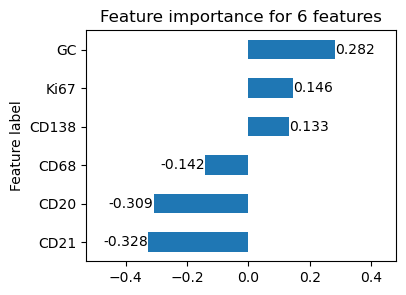

In [37]:
scores_np = [s.cpu().numpy() for s in scores]
np.mean(scores_np, axis=0)
_visualize_score(np.mean(scores_np, axis=0), ['CD21', 'CD20', 'CD68', 'Ki67', 'CD138', 'GC'])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


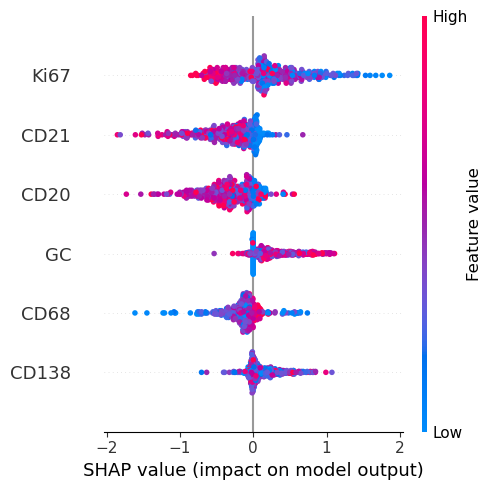

In [42]:
import shap

mean_val_np = np.stack(mean_val)
X_feature = pd.DataFrame(mean_val_np, columns=['CD21', 'CD20', 'CD68', 'Ki67', 'CD138', 'GC'])

# Plot Shap explenation
shap.summary_plot(np.stack(scores_np), X_feature, plot_size=[5,5])

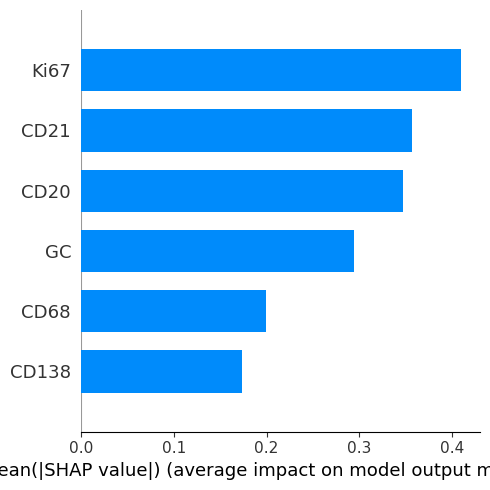

In [43]:
# Plot Shap explenation
fig = shap.summary_plot(np.stack(scores_np), X_feature, show=False, plot_type="bar",  plot_size=[5,5])
ax = plt.gca()
# ax.set_xlim(-1, 1) 
plt.show()

# Loop through all data

Here we loop through all data to get a idea of the importance of each subset edge and corresponding node to get downstream analysis statisitics 

In [31]:
from collections import defaultdict

info = defaultdict(dict)


In [32]:
for data in tqdm(dataset):
    # Get dataset and foll number
    dataset_name, foll = data.name.split('\\')[-1][3:-3].split('_')

    ### Get cell information
    # Get node info dataframe
    df_cell_info_foll = df_cell_info[(df_cell_info.Foll == int(foll)) & (df_cell_info.Dataset == dataset_name)]

    # Get spdata
    path = spatial_omics_folder / f'07_{dataset_name}.hdf5'
    spadata = SpatialOmics.from_h5py(path)

    # Assign node type
    spadata.obs[str(foll)]['name'] = df_cell_info_foll.name.tolist()

    # Get graph information
    G = spadata.G[str(foll)]['contact']
    data_graph = torch_geometric.utils.from_networkx(spadata.G[str(foll)]['contact'])
    G_new =  torch_geometric.utils.to_networkx(data, to_undirected=True)
    G_new.remove_edges_from(nx.selfloop_edges(G_new))
    pos = spadata.obs[str(foll)][['x','y']].loc[np.array(G.nodes())].to_numpy()
    cell_types =  spadata.obs[str(foll)]['name'].loc[np.array(G.nodes())].to_numpy()
    node_colors = tuple(colors_rgb_dict[n]/255 for n in cell_types)

    G = torch_geometric.utils.to_networkx(data,remove_self_loops=True, to_undirected=True)

    ### Explanation
    # Sent data to 
    data = data.to(graph_model.device)

    ### IG on edges
    explainer = Explainer(
        model=graph_model,
        algorithm=CaptumExplainer('IntegratedGradients'),
        explanation_type="model",
        node_mask_type=None,
        edge_mask_type='object',
        model_config=dict(
            mode='multiclass_classification',
            task_level='graph',
            return_type='probs',
        ),
    )
    edge_index, edge_attr = remove_self_loops(data.edge_index, data.edge_attr)
    explanation = explainer(data.x, edge_index, edge_attr=edge_attr, data=data)
    
    # Get edge_color 
    edge_color = explanation.edge_mask.detach().cpu().numpy()
    # if data.y ==0:
    #     edge_color = -edge_color
    edge_color_dict = aggregate_edge_directions(edge_color, edge_index)

    edges = tuple(edge_color_dict.keys())
    edge_color = np.array(list(edge_color_dict.values()))
    edge_color = (edge_color-np.quantile(edge_color, 0.01))/(np.quantile(edge_color, 0.99)-np.quantile(edge_color, 0.01))
    edge_color = np.clip(edge_color, a_min=0, a_max=1)

    ### GNN explainer on nodes
    explainer = Explainer(
        model=graph_model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type="model",
        node_mask_type="object",
        edge_mask_type=None,
        model_config=dict(
            mode='binary_classification',
            task_level='graph',
            return_type='probs',
        ),
    )
    explanation = explainer(data.x, data.edge_index, edge_attr=data.edge_attr, data=data)

    # Get edge_color 
    node_color = explanation.node_mask.detach().cpu().numpy()
    node_color = (node_color-node_color.min())/(node_color.max()-node_color.min())

    ### Add information to dataFrame
    info['_'.join([dataset_name, foll])]['edge'] = edge_color
    info['_'.join([dataset_name, foll])]['node'] = node_color


  0%|          | 0/442 [00:00<?, ?it/s]

In [33]:
# Save info data
save_path = (Path().cwd().parents[0]).absolute() / 'data' / 'metadata' / 'explaination_v2.pkl'

# Open a file and use dump()
with open(save_path, 'wb') as file:
      
    # A new file will be created
    pickle.dump(info, file)